In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv("data/de_matrix.tsv", sep="\t")
data["Precursor"] = data["PeptideSequence"] + "(" + data["Charge"].astype(str) + ")"
design = pd.read_csv("data/de_design_matrix.tsv", sep="\t")
data.sort_values("Protein").head(3)

,PeptideSequence,Charge,Decoy,Protein,RetentionTime,PeptideQValue,ProteinQValue,AAS_P2009_167,AAS_P2009_169,AAS_P2009_176,...,AAS_P2009_212,AAS_P2009_214,AAS_P2009_221,AAS_P2009_230,AAS_P2009_232,AAS_P2009_239,AAS_P2009_241,AAS_P2009_248,AAS_P2009_250,Precursor
14632,GAGSSEPVTGLDAK,2,0,RTpep_b,2501.380,0.0,0.0,923095000.0,795300000.0,1.023660e+09,...,1.137360e+09,1.052260e+09,1.141370e+09,1.167480e+09,1.163620e+09,1.199800e+09,1.137380e+09,1.200260e+09,1.172170e+09,GAGSSEPVTGLDAK(2)
8733,VEATFGVDESNAK,3,0,RTpep_c,2776.435,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VEATFGVDESNAK(3)
8732,VEATFGVDESNAK,2,0,RTpep_c,3229.550,0.0,0.0,6276870.0,375397000.0,1.477500e+07,...,6.646450e+06,6.445710e+06,6.479100e+06,1.158420e+07,3.819000e+06,4.889170e+08,4.857400e+08,4.882430e+08,5.447390e+06,VEATFGVDESNAK(2)


In [2]:
from generate_data import generate_pair_matrix

X_spike, y_spike = generate_pair_matrix(data, design, topn=5)
y_spike

AAS_P2009_167_sp|P50516|VATA_MOUSE_VGSHITGGDIYGIVNENSLIK_TALVANTSNMPVAAR              1.011442
AAS_P2009_167_sp|P50516|VATA_MOUSE_VGSHITGGDIYGIVNENSLIK_WEFIPSK                      1.071169
AAS_P2009_167_sp|P50516|VATA_MOUSE_VGSHITGGDIYGIVNENSLIK_ALDEYYDKHFTEFVPLR            1.071422
AAS_P2009_167_sp|P50516|VATA_MOUSE_VGSHITGGDIYGIVNENSLIK_HFTEFVPLR                    1.088376
AAS_P2009_167_sp|P50516|VATA_MOUSE_TALVANTSNMPVAAR_WEFIPSK                            1.059052
                                                                                        ...   
AAS_P2009_167_sp|P29788|VTNC_MOUSE_FEDGVLDPGYPR_GQYC(UniMod:4)YELDETAVRPGYPK          1.050969
AAS_P2009_167_sp|Q3THE2|ML12B_MOUSE_FTDEEVDELYR_GNFNYIEFTR                            1.009177
AAS_P2009_167_sp|Q571E4|GALNS_MOUSE_FYEEFPINR_GNTLMAVTLGQYK                           1.060352
AAS_P2009_167_sp|Q62188|DPYL3_MOUSE_GMTTVDDFFQGTK_AITVASQTNC(UniMod:4)PLYVTK          1.008294
AAS_P2009_167_sp|O35657|NEUR1_MOUSE_GTLLAFAEAR_HDH

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_X = scaler.fit_transform(X_spike)

X_spike = pd.DataFrame(scaled_X, index=X_spike.index, columns=X_spike.columns)
X_spike.shape

(5870, 27)

In [4]:
from xgboost import XGBRegressor

reg = XGBRegressor()
reg.fit(X_spike, y_spike.values)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

/Users/erikhartman/dev/peptide-flyability/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


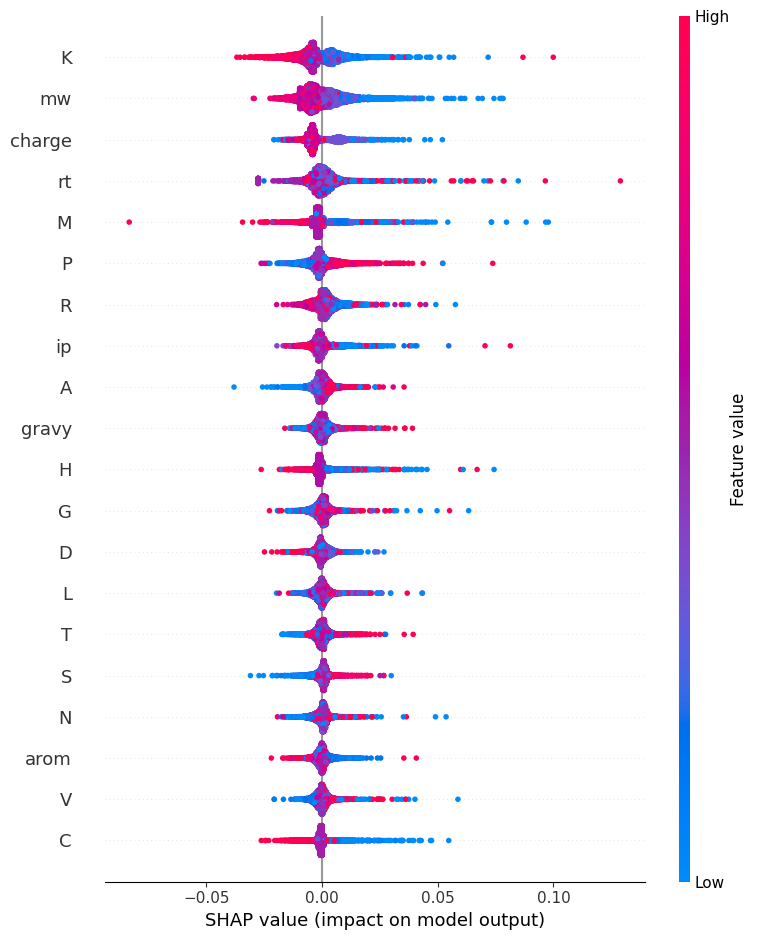

In [5]:
import shap

explainer = shap.TreeExplainer(reg)
explanation = explainer(X_spike)

shap.summary_plot(explanation)

In [8]:
data_sepsis = pd.read_csv("data/data_sepsis.tsv", sep="\t")
data_sepsis["Precursor"] = (
    data_sepsis["PeptideSequence"] + "(" + data_sepsis["Charge"].astype(str) + ")"
)
design_sepsis = pd.read_csv("data/design_sepsis.tsv", sep="\t")

X_sepsis, y_sepsis = generate_pair_matrix(data_sepsis, design_sepsis, topn=10)

X_all = pd.concat([X_sepsis, X_spike])
y_all = pd.concat([y_sepsis, y_spike])

scaler = StandardScaler()

scaled_X = scaler.fit_transform(X_all)

X_all = pd.DataFrame(scaled_X, index=X_all.index, columns=X_all.columns)

print(X_all.shape)

reg = XGBRegressor()
reg.fit(X_all, y_all.values)

(10808, 27)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

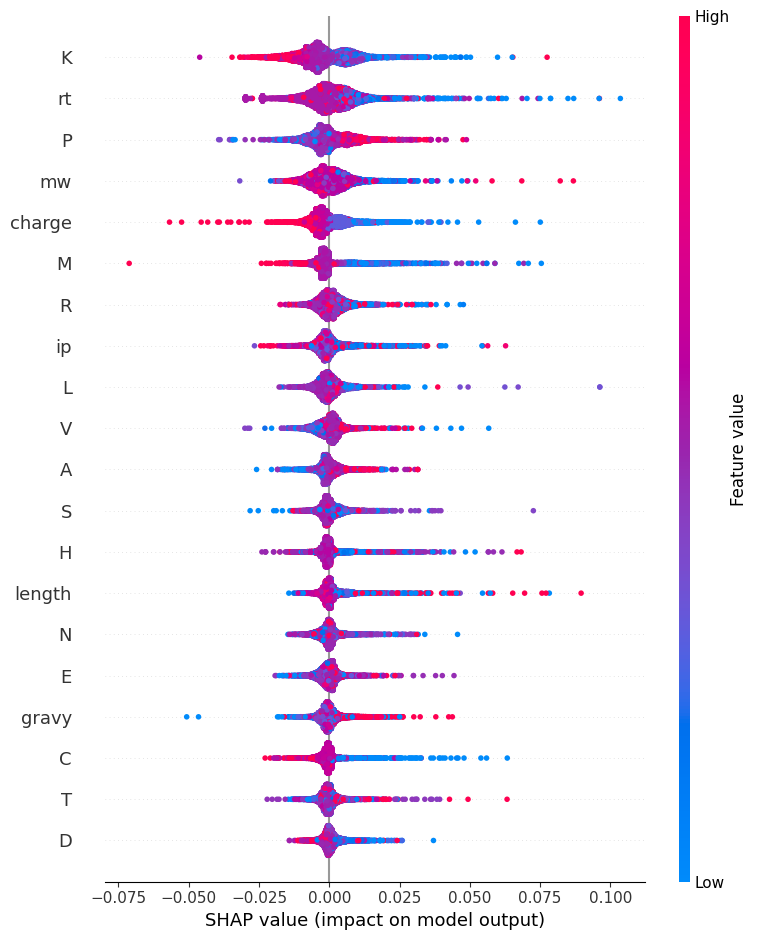

In [9]:

explainer = shap.TreeExplainer(reg)
explanation = explainer(X_all)

shap.summary_plot(explanation)